##1. 라이브러리 및 패키지 불러오기

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder # 라벨 인코더
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [4]:
! pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from bayes_opt import BayesianOptimization

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 2. 전처리

In [7]:
respec = pd.read_csv('/content/gdrive/MyDrive/BigContest_data/respec.csv')
respec.head()

,application_id,user_id,gender,insert_time,credit_score,yearly_income,income_type,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,reage,work_year
0,954900,553686,1.0,2022-06-07 14:29:03,870.0,30000000.0,PRIVATEBUSINESS,정규직,기타가족소유,30000000.0,SWITCHLOAN,0.0,1.0,1.0,27000000.0,50.0,16.0
1,137274,59516,1.0,2022-06-07 21:40:22,710.0,30000000.0,FREELANCER,기타,기타가족소유,10000000.0,LIVING,1.0,1.0,5.0,15000000.0,20.0,2.0
2,1570936,167320,1.0,2022-06-07 09:40:27,820.0,62000000.0,EARNEDINCOME,정규직,자가,2000000.0,LIVING,1.0,1.0,7.0,344000000.0,30.0,6.0
3,967833,33400,1.0,2022-06-07 08:55:07,630.0,36000000.0,EARNEDINCOME,정규직,기타가족소유,5000000.0,LIVING,0.0,0.0,1.0,16000000.0,20.0,2.0
4,1614045,860410,1.0,2022-06-07 11:29:05,590.0,45000000.0,OTHERINCOME,기타,자가,15000000.0,SWITCHLOAN,1.0,0.0,1.0,20000000.0,40.0,6.0


In [8]:
respec['employment_type'] = respec['employment_type'].replace("기타", 'ETC').replace("정규직", 'Permanent').replace("계약직", 'Temporary').replace("일용직", "Daily")

In [9]:
respec['houseown_type'] = respec['houseown_type'].replace("자가", 'Own').replace("배우자", 'Spouse').replace("전월세", 'Rent').replace("기타가족소유", "Family")

In [10]:
respec['personal_rehabilitation_yn'] = respec['personal_rehabilitation_yn'].astype('str')

In [11]:
respec['personal_rehabilitation_complete_yn'] = respec['personal_rehabilitation_complete_yn'].astype('str')

In [12]:
respec['gender'] = respec['gender'].astype('str')

In [13]:
respec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968753 entries, 0 to 968752
Data columns (total 17 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   application_id                       968753 non-null  int64  
 1   user_id                              968753 non-null  int64  
 2   gender                               968753 non-null  object 
 3   insert_time                          968753 non-null  object 
 4   credit_score                         886984 non-null  float64
 5   yearly_income                        968753 non-null  float64
 6   income_type                          968753 non-null  object 
 7   employment_type                      968753 non-null  object 
 8   houseown_type                        968753 non-null  object 
 9   desired_amount                       968753 non-null  float64
 10  purpose                              968753 non-null  object 
 11  personal_reha

In [14]:
respec_final = respec

In [15]:
respec = respec.drop(['application_id', 'user_id', 'insert_time'], axis = 1)
respec.head()

,gender,credit_score,yearly_income,income_type,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,reage,work_year
0,1.0,870.0,30000000.0,PRIVATEBUSINESS,Permanent,Family,30000000.0,SWITCHLOAN,0.0,1.0,1.0,27000000.0,50.0,16.0
1,1.0,710.0,30000000.0,FREELANCER,ETC,Family,10000000.0,LIVING,1.0,1.0,5.0,15000000.0,20.0,2.0
2,1.0,820.0,62000000.0,EARNEDINCOME,Permanent,Own,2000000.0,LIVING,1.0,1.0,7.0,344000000.0,30.0,6.0
3,1.0,630.0,36000000.0,EARNEDINCOME,Permanent,Family,5000000.0,LIVING,0.0,0.0,1.0,16000000.0,20.0,2.0
4,1.0,590.0,45000000.0,OTHERINCOME,ETC,Own,15000000.0,SWITCHLOAN,1.0,0.0,1.0,20000000.0,40.0,6.0


In [16]:
respec = pd.get_dummies(respec)

In [17]:
respec_train = respec[respec['credit_score'].notnull()]

In [18]:
respec_test = respec[respec['credit_score'].isnull()]

## 3. 모델링

#### 1) LightGBM 파라미터 조절

In [19]:
def modelFitter(colsampleByTree, subsample,maxDepth, num_leaves,learning_rate,min_child_weight):
    X = respec_train.drop('credit_score',axis=1)
    y = respec_train['credit_score']

    X_train, X_test, y_train, y_test=train_test_split(X, y,
                                                  test_size=0.2, random_state=0)
    model = LGBMRegressor(learning_rate=learning_rate, n_estimators=10000, max_depth=maxDepth.astype("int32"), subsample=subsample, colsample_bytree=colsampleByTree,num_leaves=num_leaves.astype("int32"),min_child_weight=min_child_weight)

    evalSet  = [(X_test, y_test)]
    model.fit(X_train, y_train, eval_metric="rmse", eval_set=evalSet, early_stopping_rounds=50, verbose=False)

    bestScore = model.best_score_[list(model.best_score_.keys())[0]]['rmse']

    return -bestScore

# Bounded region of parameter space
pbounds = {'colsampleByTree': (0.5,1.0), 'subsample': (0.8,1.0), 'maxDepth': (3,10), 'num_leaves': (24, 45),'learning_rate':(0.01,0.3),'min_child_weight':(5,9)}

optimizer = BayesianOptimization(
    f=modelFitter,
    pbounds=pbounds,
    random_state=1)

optimizer.maximize(init_points=5,n_iter=5) 

|   iter    |  target   | colsam... | learni... | maxDepth  | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -82.03    |  0.7085   |  0.2189   |  3.001    |  6.209    |  27.08    |  0.8185   |
|  2        | -78.15    |  0.5931   |  0.1102   |  5.777    |  7.155    |  32.8     |  0.937    |
|  3        | -81.93    |  0.6022   |  0.2647   |  3.192    |  7.682    |  32.76    |  0.9117   |
|  4        | -77.17    |  0.5702   |  0.06745  |  8.605    |  8.873    |  30.58    |  0.9385   |
|  5        | -81.78    |  0.9382   |  0.2694   |  3.595    |  5.156    |  27.57    |  0.9756   |
|  6        | -81.8     |  0.5588   |  0.01     |  9.255    |  7.033    |  33.16    |  0.9732   |
|  7        | -76.87    |  0.5799   |  0.09037  |  7.528    |  8.569    |  30.94    |  0.9325   |
|  8        | -82.16    |  1.0      |  0.01     |  7.342    |  9.0      |  28.9     |  0.8      |
|  9        | -73.78

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[5003]	valid_0's rmse: 76.398	valid_0's l2: 5836.65
[5004]	valid_0's rmse: 76.3988	valid_0's l2: 5836.78
[5005]	valid_0's rmse: 76.3985	valid_0's l2: 5836.74
[5006]	valid_0's rmse: 76.3995	valid_0's l2: 5836.88
[5007]	valid_0's rmse: 76.3989	valid_0's l2: 5836.79
[5008]	valid_0's rmse: 76.3984	valid_0's l2: 5836.72
[5009]	valid_0's rmse: 76.3976	valid_0's l2: 5836.6
[5010]	valid_0's rmse: 76.3968	valid_0's l2: 5836.47
[5011]	valid_0's rmse: 76.3965	valid_0's l2: 5836.43
[5012]	valid_0's rmse: 76.3943	valid_0's l2: 5836.09
[5013]	valid_0's rmse: 76.3942	valid_0's l2: 5836.08
[5014]	valid_0's rmse: 76.3941	valid_0's l2: 5836.06
[5015]	valid_0's rmse: 76.3927	valid_0's l2: 5835.85
[5016]	valid_0's rmse: 76.3929	valid_0's l2: 5835.88
[5017]	valid_0's rmse: 76.3898	valid_0's l2: 5835.4
[5018]	valid_0's rmse: 76.3901	valid_0's l2: 5835.45
[5019]	valid_0's rmse: 76.3896	valid_0's l2: 5835.37
[5020]	valid_0's rmse: 76.3893	valid_0's l2: 5835.33
[5021]	valid_

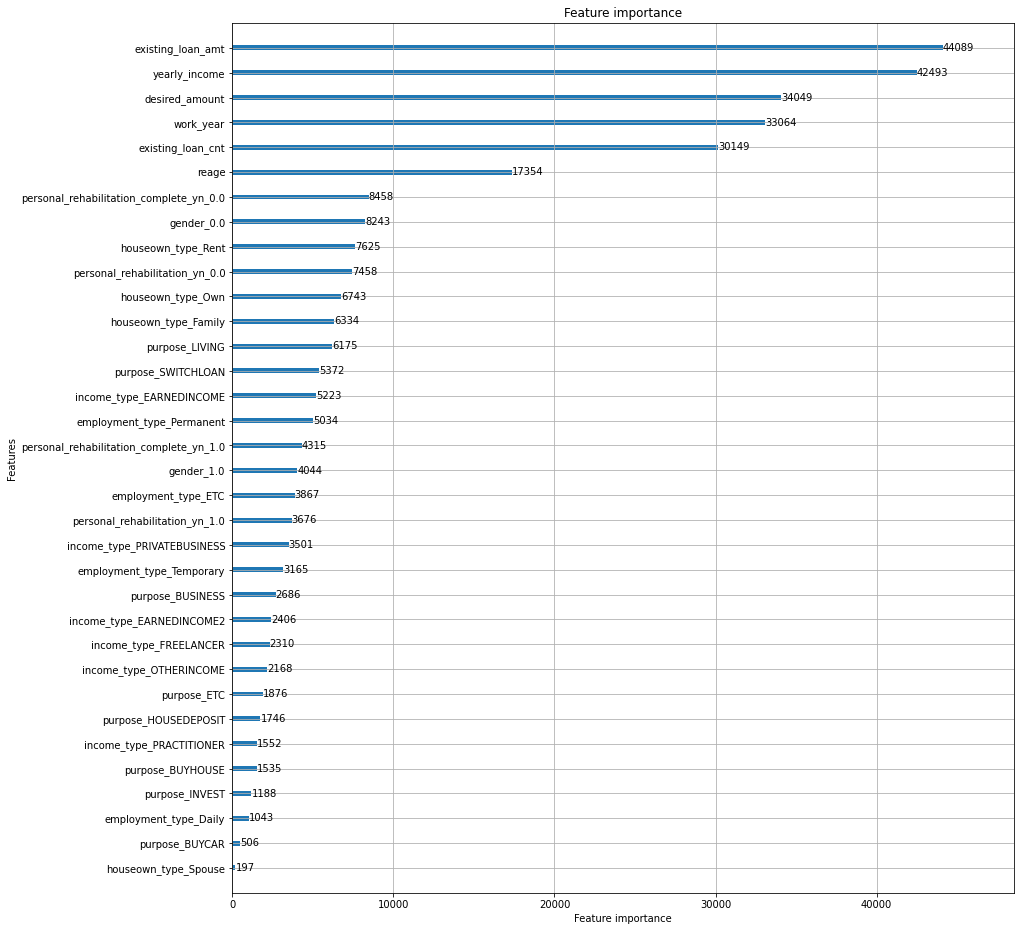

In [20]:
X = respec_train.drop('credit_score',axis=1)
y = respec_train['credit_score']

X_train1, X_test1, y_train1, y_test1=train_test_split(X, y,
                                                 test_size=0.2, random_state=1)
                        
lgbm = LGBMRegressor(n_estimators=10000, learning_rate=0.3, num_leaves=32, sumbsample=0.5, colsample_bytree=0.5, max_depth=8,
                             min_child_weight=9)
evals = [(X_test1, y_test1)]
lgbm.fit(X_train1, y_train1, early_stopping_rounds=100, eval_metric='rmse', eval_set=evals, verbose=True)
preds = lgbm.predict(X_test1)

from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(14, 16))
plot_importance(lgbm, ax=ax)

In [21]:
# train rmse
import math
lgbm_predict = lgbm.predict(X_train1)
print("RMSE:{}".format(math.sqrt(mean_squared_error(lgbm_predict, y_train1))) )

RMSE:59.16006693545053


In [22]:
# test rmse
lgbm_predict = lgbm.predict(X_test1)
print("RMSE:{}".format(math.sqrt(mean_squared_error(lgbm_predict, y_test1))) )

RMSE:74.30955701905775


### 2) LightGBM 과적합 개선

In [23]:
respec_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886984 entries, 0 to 968751
Data columns (total 35 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   credit_score                             886984 non-null  float64
 1   yearly_income                            886984 non-null  float64
 2   desired_amount                           886984 non-null  float64
 3   existing_loan_cnt                        886984 non-null  float64
 4   existing_loan_amt                        886984 non-null  float64
 5   reage                                    886984 non-null  float64
 6   work_year                                886984 non-null  float64
 7   gender_0.0                               886984 non-null  uint8  
 8   gender_1.0                               886984 non-null  uint8  
 9   income_type_EARNEDINCOME                 886984 non-null  uint8  
 10  income_type_EARNEDINCOME2       

In [32]:
def modelFitter2(colsampleByTree, subsample,maxDepth, num_leaves,learning_rate,min_child_weight):
    X = respec_train.drop(['credit_score','houseown_type_Spouse', 'purpose_BUYCAR', 'employment_type_Daily', 'purpose_INVEST', 'purpose_BUYHOUSE', 'income_type_PRACTITIONER', 'purpose_HOUSEDEPOSIT', 'purpose_ETC'],axis=1)
    y = respec_train['credit_score']

    X_train, X_test, y_train, y_test=train_test_split(X, y,
                                                  test_size=0.2, random_state=0)
    model = LGBMRegressor(learning_rate=learning_rate, n_estimators=10000, max_depth=maxDepth.astype("int32"), subsample=subsample, colsample_bytree=colsampleByTree,num_leaves=num_leaves.astype("int32"),min_child_weight=min_child_weight)

    evalSet  = [(X_test, y_test)]
    model.fit(X_train, y_train, eval_metric="rmse", eval_set=evalSet, early_stopping_rounds=50, verbose=False)

    bestScore = model.best_score_[list(model.best_score_.keys())[0]]['rmse']

    return -bestScore

# Bounded region of parameter space
pbounds = {'colsampleByTree': (0.5,1.0), 'subsample': (0.8,1.0), 'maxDepth': (3,10), 'num_leaves': (24, 45),'learning_rate':(0.01,0.3),'min_child_weight':(5,9)}

optimizer = BayesianOptimization(
    f=modelFitter2,
    pbounds=pbounds,
    random_state=1)

optimizer.maximize(init_points=5,n_iter=5) 

|   iter    |  target   | colsam... | learni... | maxDepth  | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -82.25    |  0.7085   |  0.2189   |  3.001    |  6.209    |  27.08    |  0.8185   |
|  2        | -78.28    |  0.5931   |  0.1102   |  5.777    |  7.155    |  32.8     |  0.937    |
|  3        | -82.14    |  0.6022   |  0.2647   |  3.192    |  7.682    |  32.76    |  0.9117   |
|  4        | -77.39    |  0.5702   |  0.06745  |  8.605    |  8.873    |  30.58    |  0.9385   |
|  5        | -81.94    |  0.9382   |  0.2694   |  3.595    |  5.156    |  27.57    |  0.9756   |
|  6        | -81.9     |  0.5647   |  0.01     |  9.134    |  7.015    |  33.11    |  0.9737   |
|  7        | -76.77    |  0.579    |  0.0912   |  7.549    |  8.605    |  30.91    |  0.932    |
|  8        | -82.23    |  1.0      |  0.01     |  7.113    |  9.0      |  29.07    |  0.8      |
|  9        | -73.72

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[5003]	valid_0's rmse: 76.3937	valid_0's l2: 5836
[5004]	valid_0's rmse: 76.3937	valid_0's l2: 5836
[5005]	valid_0's rmse: 76.3933	valid_0's l2: 5835.94
[5006]	valid_0's rmse: 76.3931	valid_0's l2: 5835.9
[5007]	valid_0's rmse: 76.3922	valid_0's l2: 5835.76
[5008]	valid_0's rmse: 76.3925	valid_0's l2: 5835.82
[5009]	valid_0's rmse: 76.3927	valid_0's l2: 5835.84
[5010]	valid_0's rmse: 76.391	valid_0's l2: 5835.59
[5011]	valid_0's rmse: 76.3905	valid_0's l2: 5835.5
[5012]	valid_0's rmse: 76.3905	valid_0's l2: 5835.51
[5013]	valid_0's rmse: 76.3892	valid_0's l2: 5835.32
[5014]	valid_0's rmse: 76.3889	valid_0's l2: 5835.27
[5015]	valid_0's rmse: 76.3892	valid_0's l2: 5835.31
[5016]	valid_0's rmse: 76.3888	valid_0's l2: 5835.26
[5017]	valid_0's rmse: 76.3871	valid_0's l2: 5834.98
[5018]	valid_0's rmse: 76.3858	valid_0's l2: 5834.79
[5019]	valid_0's rmse: 76.385	valid_0's l2: 5834.67
[5020]	valid_0's rmse: 76.3846	valid_0's l2: 5834.61
[5021]	valid_0's rms

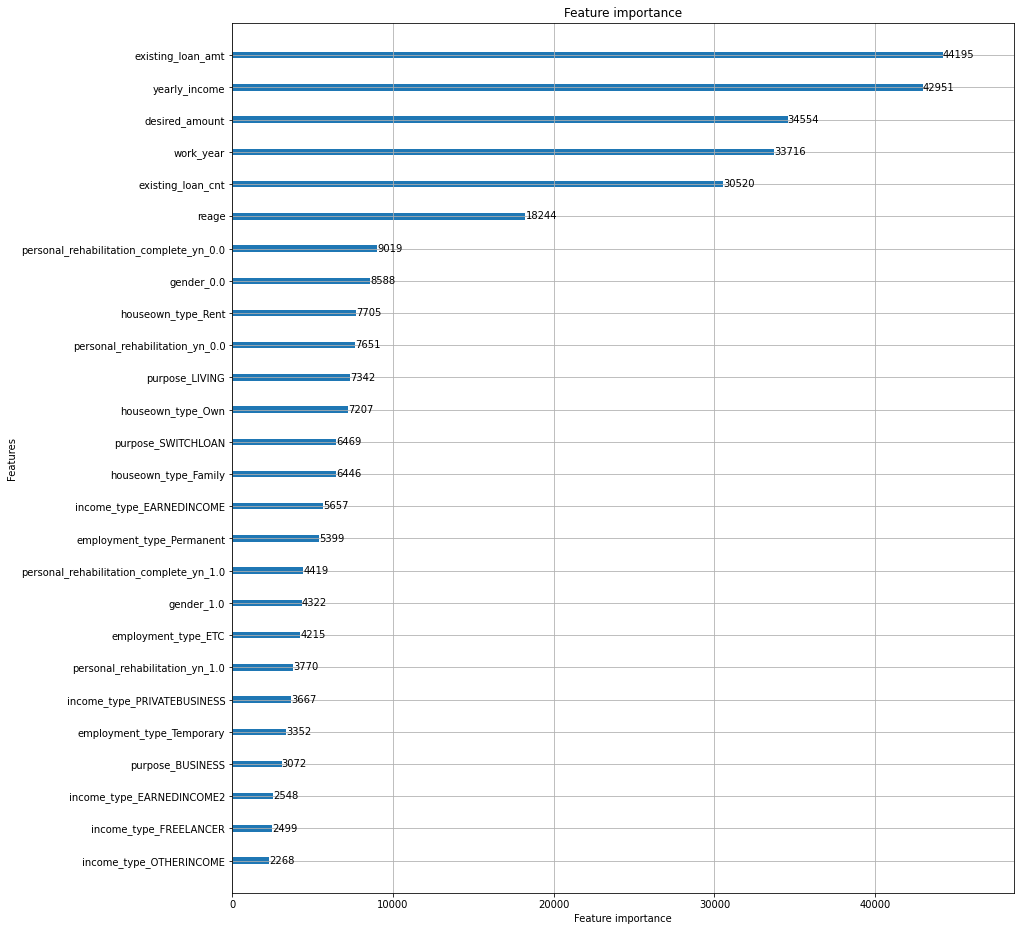

In [38]:
X2 = respec_train.drop(['credit_score','houseown_type_Spouse', 'purpose_BUYCAR', 'employment_type_Daily', 'purpose_INVEST', 'purpose_BUYHOUSE', 'income_type_PRACTITIONER', 'purpose_HOUSEDEPOSIT', 'purpose_ETC'],axis=1)
y2 = respec_train['credit_score']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2,
                                                 test_size=0.2, random_state=1)
lgbm2 = LGBMRegressor(n_estimators=10000, learning_rate=0.3, num_leaves=32, sumbsample=1, colsample_bytree=0.5, max_depth=8, min_child_weight=9)
evals2 = [(X_test2, y_test2)]
lgbm2.fit(X_train2, y_train2, early_stopping_rounds=100, eval_metric='rmse', eval_set=evals2, verbose=True)
preds2 = lgbm2.predict(X_test2)

from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 16))
plot_importance(lgbm2, ax=ax)

In [39]:
# train rmse
import math
lgbm_predict = lgbm2.predict(X_train2)
print("RMSE:{}".format(math.sqrt(mean_squared_error(lgbm_predict, y_train2))) )

RMSE:59.54387777477542


In [40]:
# test rmse
lgbm_predict = lgbm2.predict(X_test2)
print("RMSE:{}".format(math.sqrt(mean_squared_error(lgbm_predict, y_test2))) )

RMSE:74.23089410432372
